# An Analysis of Flight Delays

In an era where efficiency and customer satisfaction are crucial, understanding the causes of flight delays and cancellations is essential for the airline industry. This notebook presents a detailed analysis of flight delays across U.S. airports from August 2013 to August 2023. By investigating trends such as peak years for delays and cancellations, carrier reliability, and the impact of weather conditions, we aim to provide businesses with data-driven strategies to enhance operational efficiency and customer service. This analysis will equip airlines, airport operators, and related stakeholders with the intelligence needed to optimize performance, reduce delays, and improve the overall travel experience, thereby driving competitive advantage and growth.

We will focus on finding answers to these questions:
- Which airport has the greatest chance of a flight delay?
- Which carrier is the most reliable?
- What are the most popular carriers?
- Is there a trend in delays over the years?

In [235]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [61]:
conn = pymysql.connect(host = "localhost",
                       port = int(3306),
                       user = "root",
                       password = "kart1103",
                       db = "airline_delay_causes")

Before we get into the analysis, let's take a look at the columns of our three tables.

In [108]:
query = """
    SELECT *
    FROM airline_delays;
"""
pd.read_sql_query(query, conn)

,year,month,carrier_code,airport_code,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled_ct,arr_diverted_ct,arr_delay_min,carrier_delay_min,weather_delay_min,nas_delay_min,security_delay_min,late_aircraft_delay_min
0,2023,8,9E,ABE,89,13,2,2,3,0,6,2,1,1375,71,761,118,0,425
1,2023,8,9E,ABY,62,10,2,0,1,0,7,0,1,799,218,1,62,0,518
2,2023,8,9E,AEX,62,10,3,1,2,0,4,1,0,766,56,188,78,0,444
3,2023,8,9E,AGS,66,12,4,2,4,0,2,1,1,1397,471,320,388,0,218
4,2023,8,9E,ALB,92,22,8,0,3,0,11,2,0,1530,628,0,134,0,768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171661,2013,8,YV,TRI,7,1,1,0,0,0,0,0,0,23,18,0,5,0,0
171662,2013,8,YV,YUM,2,1,0,0,0,0,1,0,0,17,0,0,0,0,17
171663,2013,8,YV,SLC,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
171664,2013,8,DL,SBN,1,1,1,0,0,0,0,0,0,18,18,0,0,0,0


This table is called __airline_delays__ and shows counts of arrivals and delays for every year and airport.
- __year__: The year of the data
- __month__: The month of the data
- __carrier_code__: Carrier code
- __airport_code__: Airport code
- __arr_flights__: Number of arriving flights
- __arr_del15__: Number of flights delayed by 15 minutes or more
- __carrier_ct__: Carrier count (delay due to the carrier)
- __weather_ct__: Weather count (delay due to weather)
- __nas_ct__: NAS (National Airspace System) count (delay due to the NAS)
- __security_ct__: Security count (delay due to security)
- __late_aircraft_ct__: Late aircraft count (delay due to late aircraft arrival)
- __arr_cancelled_ct__: Number of flights canceled
- __arr_diverted_ct__: Number of flights diverted
- __arr_delay_min__: Total arrival delay (in min)
- __carrier_delay_min__: Delay attributed to the carrier (in min)
- __weather_delay_min__: Delay attributed to weather (in min)
- __nas_delay_min__: Delay attributed to the NAS (in min)
- __security_delay_min__: Delay attributed to security (in min)
- __late_aircraft_delay_min__: Delay attributed to late aircraft arrival (in min)ircraft arrival.

In [106]:
query = """
    SELECT *
    FROM airline_list;
"""
pd.read_sql_query(query, conn)

,carrier_code,carrier_name
0,9E,Endeavor Air Inc.\r
1,9E,Endeavor Air Inc.\r
2,9E,Endeavor Air Inc.\r
3,9E,Endeavor Air Inc.\r
4,9E,Endeavor Air Inc.\r
...,...,...
686659,YV,Mesa Airlines Inc.\r
686660,YV,Mesa Airlines Inc.\r
686661,YV,Mesa Airlines Inc.\r
686662,DL,Delta Air Lines Inc.\r


This table is called __airline_list__ and shows the abbreviated codes of all carriers and their full names. Notice how there are multiple duplicate rows; this will change how we approach some of the questions later on.
- __carrier_code__: Carrier code
- __carrier_name__: Carrier name

In [104]:
query = """
    SELECT *
    FROM airport_list;
"""
pd.read_sql_query(query, conn)

,airport_code,airport_city,airport_name
0,ABE,Allentown/Bethlehem/Easton. PA,Lehigh Valley International\r
1,ABY,Albany. GA,Southwest Georgia Regional\r
2,AEX,Alexandria. LA,Alexandria International\r
3,AGS,Augusta. GA,Augusta Regional at Bush Field\r
4,ALB,Albany. NY,Albany International\r
...,...,...,...
171661,TRI,Bristol/Johnson City/Kingsport. TN,Tri Cities\r
171662,YUM,Yuma. AZ,Yuma MCAS/Yuma International\r
171663,SLC,Salt Lake City. UT,Salt Lake City International\r
171664,SBN,South Bend. IN,South Bend International\r


This table is called __airport_list__ and shows the code, name, and the city of all airports. Same as the airline_list table, this table has multiple duplicate rows as well.
- __airport_code__: Airport code
- __airport_city__: City where airport is located in
- __airport_name__: Airport name

## General Analysis

Let's start by answering basic questions.
How many flights were delayed by 15 minutes or more each year?

In [110]:
query = """
    SELECT year, SUM(arr_del15) AS delayed_flights
    FROM airline_delays GROUP BY year;
"""
pd.read_sql_query(query, conn)

,year,delayed_flights
0,2023,1023586.0
1,2022,1376798.0
2,2021,1010332.0
3,2020,431921.0
4,2019,1389253.0
5,2018,1352165.0
6,2017,1029474.0
7,2016,964239.0
8,2015,1063439.0
9,2014,1240528.0


Now, what is the average amount of delay due to weather?

In [133]:
query = """
    SELECT SUM(weather_delay_min) / SUM(weather_ct) AS avg_weather_delay
    FROM airline_delays;
"""
pd.read_sql_query(query, conn)

,avg_weather_delay
0,98.8799


## Delay and Cancellation Trends

Now we dive into analyzing trends. Analyzing flight delay and cancellation trends over the years allows airlines and airports to optimize operations, enhance customer satisfaction, and manage costs more effectively. Let's start by finding out which years had the most/least delays and cancellations.

In [221]:
query = """
    SELECT year, SUM(arr_del15) + SUM(arr_cancelled_ct) AS del_cancel_ct
    FROM airline_delays
    GROUP BY year
    ORDER BY del_cancel_ct DESC;
"""
pd.read_sql_query(query, conn)

,year,del_cancel_ct
0,2022,1558084.0
1,2019,1524178.0
2,2018,1468704.0
3,2014,1367512.0
4,2015,1153323.0
5,2021,1113392.0
6,2017,1112167.0
7,2023,1099204.0
8,2016,1030100.0
9,2020,712955.0


We can see that 2022 had the most delays and cancellations. However, it is hard to see a trend in a table form. Let's visualize this table to see the trend.

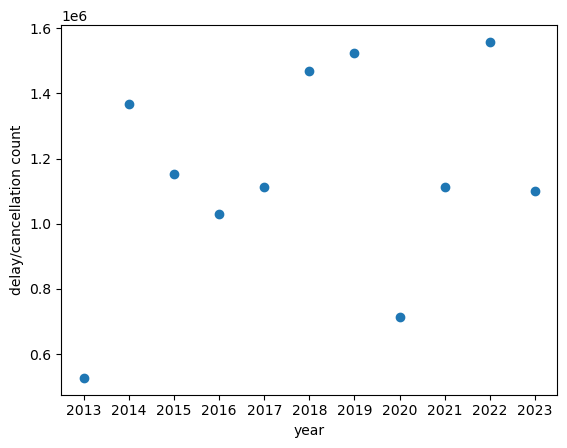

In [241]:
x = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
y = [526473, 1367512, 1153323, 1030100, 1112167, 1468704, 1524178, 712955, 1113392, 1558084, 1099204]
plt.xlabel('year')
plt.ylabel('delay/cancellation count')
plt.xticks(np.linspace(2013,2023,11))
plt.scatter(x,y)
plt.show()

There is no visible trend in delays and cancellations, but we can clearly see the negative effects of Covid-19 on flights, as there is a sudden drop in 2020 which gradually returns back to normal as the world recovers from the virus.

## Carrier Popularity

By researching carrier popularity, we can understand market preferences and identify customer loyalty trends, which allows airlines to tailor their services, pricing, and marketing strategies to attract and retain customers. The question we will answer is: which carriers are the most popular? We will use the arriving flight count to determine carriers' popularity.

Since we will be using the airline_list table (which has multiple duplicate rows!!!), we need to clean it and create a CTE to combine two tables.

In [143]:
query = """
    WITH flight_count_table AS (
            SELECT carrier_code, SUM(arr_flights) AS flight_count
            FROM airline_delays
            GROUP BY carrier_code),
         airline_table AS (
            SELECT carrier_code, carrier_name
            FROM airline_list
            GROUP BY carrier_code, carrier_name)
    SELECT a.carrier_name, f.flight_count
    FROM flight_count_table AS f
    JOIN airline_table AS a
      ON f.carrier_code = a.carrier_code
    ORDER BY f.flight_count DESC;
"""
pd.read_sql_query(query, conn)

,carrier_name,flight_count
0,Southwest Airlines Co.\r,12522217.0
1,Delta Air Lines Inc.\r,8661561.0
2,American Airlines Inc.\r,7973061.0
3,SkyWest Airlines Inc.\r,6905066.0
4,United Air Lines Inc.\r,5464237.0
5,ExpressJet Airlines LLC\r,2786903.0
6,ExpressJet Airlines Inc.\r,2786903.0
7,JetBlue Airways\r,2609697.0
8,Envoy Air\r,2353240.0
9,American Eagle Airlines Inc.\r,2353240.0


No surprise in Southwest, Delta, and American Airlines for being the top 3 most popular airlines! However, it is unexpected that SkyWest had more flights than United as the latter is part of the "big four" airlines of the U.S. (Southwest, Delta, American, United).

## Airport Reliability

Let's see which airports are the most unreliable. Customers' experiences with flying may be tied to problems they encounter in the airport, so analyzing airport reliability is crucial for maximizing customer satisfaction. Since security is one of the biggest factors in delays between airports, we will use security_ct to gauge which airports are the most reliable.

In [195]:
query = """
    WITH sec_per_table AS (
             SELECT airport_code, CAST(SUM(arr_flights) AS UNSIGNED) AS total_flights, (SUM(security_ct) / SUM(arr_flights)) * 100 AS percentage
             FROM airline_delays
             GROUP BY airport_code),
         airport_table AS (
             SELECT airport_code, airport_city, airport_name
             FROM airport_list
             GROUP BY airport_code, airport_city, airport_name)
    SELECT a.airport_name, a.airport_city, s.total_flights, s.percentage
    FROM sec_per_table AS s
    JOIN airport_table AS a
      ON s.airport_code = a.airport_code
    ORDER BY s.percentage DESC
    LIMIT 5;
"""
pd.read_sql_query(query, conn)

,airport_name,airport_city,total_flights,percentage
0,Cold Bay Airport\r,Cold Bay. AK,262,7.6336
1,Ted Stevens Anchorage International\r,Anchorage. AK,178310,0.6657
2,Pago Pago International\r,Pago Pago. TT,936,0.6410
3,Adak\r,Adak Island. AK,1052,0.3802
4,Atlantic City International\r,Atlantic City. NJ,28172,0.2627


We can see that Cold Bay Airport in Alaska has a whopping 7.63 percent security delay rate! However, it has a relatively low flight count compared to other airports so the percentage may be exaggerated. Still, we should be wary of running into a security problem when catching a flight at Cold Bay Airport!

## Carrier Reliability

Now that we know which airport to avoid, let's rank the carriers in reliability. Since we don't have all the data of every airline, we will be using average minutes per delay as the measure of carrier reliability.

In [247]:
query = """
    WITH rank_table AS (
             SELECT carrier_code, SUM(carrier_delay_min) / SUM(carrier_ct) AS min_per_delay, RANK() OVER(ORDER BY SUM(carrier_delay_min) / SUM(carrier_ct)) AS position
             FROM airline_delays
             GROUP BY carrier_code),
         airline_table AS (
             SELECT carrier_code, carrier_name
             FROM airline_list
             GROUP BY carrier_code, carrier_name)
    SELECT a.carrier_name, r.min_per_delay, r.position
    FROM airline_table AS a
    JOIN rank_table AS r
      ON a.carrier_code = r.carrier_code
    ORDER BY r.position;
"""
pd.read_sql_query(query, conn)

,carrier_name,min_per_delay,position
0,AirTran Airways Corporation\r,42.9270,1
1,Hawaiian Airlines Inc.\r,44.6091,2
2,Southwest Airlines Co.\r,49.0092,3
3,US Airways Inc.\r,53.6895,4
4,Virgin America\r,54.2313,5
5,Horizon Air\r,55.5540,6
6,Alaska Airlines Inc.\r,58.8720,7
7,Envoy Air\r,65.7480,8
8,American Eagle Airlines Inc.\r,65.7480,8
9,United Air Lines Inc.\r,65.8497,9


AirTran Airways takes first place as the most reliable carrier, while Allegiant Air places last. Better avoid Allegiant Air!

## Conclusion

This project provides valuable insights into the factors influencing flight delays and cancellations across U.S. airports over the past decade. By analyzing patterns in flight delays, we've found areas of improvement for airline corporations, airports, and even customers. With these findings, industries and stakeholders can make informed decisions, boost performance, and create a smoother travel experience for everyone.